In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rsrch.vqvae.pixelcnn import PixelCNN
from rsrch.datasets import font_awesome, tiny_imagenet
import torch
from torch.distributions import Categorical
from torch import Tensor
import rsrch.utils.data as data
import torchvision.transforms.functional as F
from pathlib import Path


class Trainer:
    def __init__(self):
        self.train_batch_size = 16
        self.val_batch_size = 16
        self.num_workers = 4
        self.num_epochs = 32
        self.val_every = 16

    def setup(self):
        self.setup_data()
        self.setup_model()

    def setup_data(self):
        # self.setup_font_awesome()
        self.setup_tiny_imagenet()

    def setup_font_awesome(self):
        ds_root = Path(__file__).parent / "../datasets/font-awesome"

        self.ds = font_awesome.FontAwesome(
            root=ds_root,
            color="black",
            resolution=32,
        )

        self._in_channels = 1
        self._value_range = 2

        self.train_ds, self.val_ds = data.random_split(self.ds, [0.8, 0.2])

        def val_transform(item: font_awesome.Item) -> Tensor:
            image = item.image.split()[-1]
            image = F.to_tensor(image)
            image = (image > 0.5).float()
            image = F.center_crop(image, (32, 32))
            return image

        self.val_ds = self.val_ds.map(val_transform)
        self.val_loader = data.DataLoader(
            dataset=self.val_ds,
            batch_size=self.val_batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=self.num_workers,
        )

        def train_transform(item: font_awesome.Item) -> Tensor:
            image = val_transform(item)
            return image

        self.train_ds = self.train_ds.map(train_transform)
        self.train_loader = data.DataLoader(
            dataset=self.train_ds,
            batch_size=self.train_batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def setup_tiny_imagenet(self):
        ds_root = Path(__file__).parent / "../datasets/tiny-imagenet-200"

        self.train_ds = tiny_imagenet.TinyImageNet(root=ds_root, split="train")

        self.val_ds = tiny_imagenet.TinyImageNet(
            root=ds_root,
            split="val",
        )

        self._in_channels = 3
        self._value_range = 256

        def val_transform(item: font_awesome.Item) -> Tensor:
            image = item.image
            image = image.convert("RGB")
            image = F.center_crop(image, (32, 32))
            image = F.to_tensor(image)
            return image

        self.val_ds = self.val_ds.map(val_transform)
        self.val_loader = data.DataLoader(
            dataset=self.val_ds,
            batch_size=self.val_batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=self.num_workers,
        )

        def train_transform(item: font_awesome.Item) -> Tensor:
            image = val_transform(item)
            return image

        self.train_ds = self.train_ds.map(train_transform)
        self.train_loader = data.DataLoader(
            dataset=self.train_ds,
            batch_size=self.train_batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def setup_model(self):
        self.model = PixelCNN(
            in_channels=self._in_channels,
            hidden_dim=128,
            value_range=self._value_range,
            kernel_size=7,
            num_layers=9,
        )

    def train(self):
        self.device = torch.device("cuda")
        self.model = self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        for epoch in range(self.num_epochs):
            for batch in self.train_loader:
                batch = batch.to(self.device)
                logits = self.model(batch)
                pr_dist = Categorical(logits=logits)
                targets = self._value_range * batch
                targets = targets.clamp(0, self._value_range - 1).long()
                loss = -pr_dist.log_prob(targets).sum()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epoch % self.val_every == 0:
                val_loss, num_items = 0, 0
                for batch in self.val_loader:
                    batch = batch.to(self.device)
                    logits = self.model(batch)
                    pr_dist = Categorical(logits=logits)
                    targets = self._value_range * batch
                    targets = targets.clamp(0, self._value_range - 1).long()
                    val_loss += -pr_dist.log_prob(targets).sum().item()
                    num_items += len(batch)

                val_loss = val_loss / num_items
                print(f"val | epoch={epoch}, val_loss={val_loss}")


ImportError: cannot import name 'TinyImagenet' from 'rsrch.datasets.tiny_imagenet' (/home/j.bednarz/projects/rsrch/rsrch/datasets/tiny_imagenet.py)

In [ ]:
trainer = Trainer()
trainer.num_epochs = 128
trainer.setup()
trainer.train()

KeyboardInterrupt: 

In [ ]:
batch = trainer.val_ds[0].unsqueeze(0)
batch = batch.to(trainer.device)
pred = trainer.model.predict(batch, (16, 16))[0]

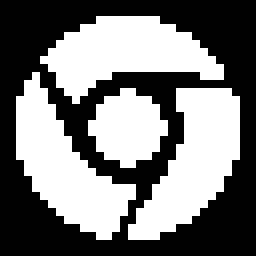

In [ ]:
import torchvision.transforms.functional as F
image = trainer.val_ds[3]
F.to_pil_image(image).resize((256, 256), 0)

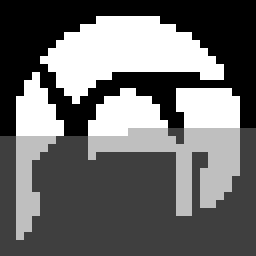

In [ ]:
import numpy as np
batch = image.unsqueeze(0).to(trainer.device)
pred = trainer.model.predict(batch, (16, 16))[0]
for iy, ix, ic in np.ndindex((32, 32, 1)):
    if (iy, ix) >= (16, 16):
        pred[ic,iy,ix] = 0.25 + 0.5 * pred[ic,iy,ix]
F.to_pil_image(pred).resize((256, 256), 0)